In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate

In [2]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [5]:
np.__version__

'1.26.4'

In [6]:
# Define dataset path
TESS_PATH = r"C:\Users\bharg\Downloads\TESS Toronto emotional speech set data"

In [7]:
# Function to extract MFCC features
def extract_features(audio_path, sr=16000, n_mfcc=40):
    """Loads an audio file and extracts MFCC features."""
    y, sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = np.mean(mfcc, axis=1)  # Take mean along time axis to get a fixed-length feature vector
    return mfcc


In [8]:
# Load dataset
X_audio, X_text, y = [], [], []
labels_map = {}
label_index = 0
words_set = set()

In [9]:
for root, dirs, files in os.walk(TESS_PATH):
    for file in files:
        if file.endswith(".wav"):  # Ensure it's an audio file
            parts = file.split("_")
            word = parts[1]  # Extract spoken word
            label = parts[-1].replace(".wav", "")  # Extract emotion label from filename
            
            if label not in labels_map:
                labels_map[label] = label_index
                label_index += 1
            
            file_path = os.path.join(root, file)
            features = extract_features(file_path)
            
            X_audio.append(features)
            X_text.append(word)  # Store word as text input
            y.append(labels_map[label])
            words_set.add(word)

In [10]:
# Convert to NumPy arrays
X_audio = np.array(X_audio)
y = np.array(y)
y = to_categorical(y, num_classes=len(labels_map))  # One-hot encode labels


In [11]:
# Encode words as numerical values
word_encoder = LabelEncoder()
X_text = word_encoder.fit_transform(X_text)
X_text = np.expand_dims(X_text, axis=-1)  # Expand dimensions for

In [12]:
# Split into train and test sets
X_audio_train, X_audio_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_audio, X_text, y, test_size=0.2, random_state=42)

In [13]:
# Update model pipeline (ensure it matches expected input shape)
input_shape_audio = (X_audio_train.shape[1],)
input_shape_text = (X_text_train.shape[1],)


In [14]:
print("Dataset Loaded Successfully!")
print(f"Training Samples: {X_audio_train.shape[0]}, Testing Samples: {X_audio_test.shape[0]}")
print(f"Emotion Labels: {labels_map}")
print(f"Unique Words in Dataset: {len(words_set)}")


Dataset Loaded Successfully!
Training Samples: 2240, Testing Samples: 560
Emotion Labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'ps': 5, 'sad': 6}
Unique Words in Dataset: 200


In [15]:
# Define the audio input branch
audio_input = Input(shape=input_shape_audio, name="audio_input")
x_audio = Dense(128, activation="relu")(audio_input)
x_audio = Dropout(0.3)(x_audio)
x_audio = Dense(64, activation="relu")(x_audio)

In [16]:
# Define the text input branch
text_input = Input(shape=input_shape_text, name="text_input")
x_text = Embedding(input_dim=len(words_set) + 1, output_dim=16)(text_input)
x_text = Flatten()(x_text)
x_text = Dense(32, activation="relu")(x_text)

In [17]:
# Fusion layer
merged = Concatenate()([x_audio, x_text])
merged = Dense(64, activation="relu")(merged)
merged = Dropout(0.3)(merged)
output = Dense(len(labels_map), activation="softmax", name="output_layer")(merged)

In [18]:
# Build and compile the model
model = Model(inputs=[audio_input, text_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [19]:
# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      5,248 │ audio_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 16)     │      3,216 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        544 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 7)         │        455 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,927 (93.46 KB)

 Trainable params: 23,927 (93.46 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Visualize model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [21]:
# Train the model
history = model.fit(
    [X_audio_train, X_text_train], y_train,
    validation_data=([X_audio_test, X_text_test], y_test),
    epochs=30, batch_size=32, verbose=1
)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1673 - loss: 15.9763 - val_accuracy: 0.3018 - val_loss: 1.6286
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2135 - loss: 3.0268 - val_accuracy: 0.3768 - val_loss: 1.7733
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2356 - loss: 1.9482 - val_accuracy: 0.5214 - val_loss: 1.5476
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3187 - loss: 1.6945 - val_accuracy: 0.5804 - val_loss: 1.2907
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3485 - loss: 1.5726 - val_accuracy: 0.6286 - val_loss: 1.1584
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4147 - loss: 1.3876 - val_accuracy: 0.7268 - val_loss: 0.9449
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4624 - loss: 1.2906 - val_accuracy: 0.7357 - val_loss: 0.8305
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5359 - loss: 1.1408 - val_accuracy: 0.7946 - val_loss

Text(0.5, 1.0, 'Model Accuracy')

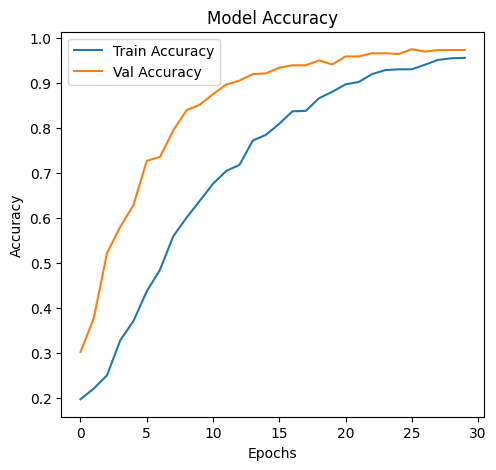

In [22]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

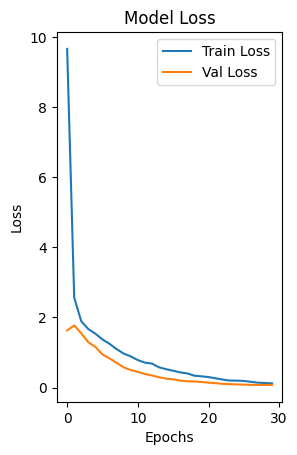

In [23]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [24]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix

In [25]:
y_pred = model.predict([X_audio_test, X_text_test])

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [26]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [27]:
y_pred

array([[4.99287504e-04, 5.38776570e-04, 2.65239208e-07, ...,
        8.48014636e-09, 9.95369017e-01, 7.40068895e-10],
       [1.10210560e-03, 7.31688706e-05, 2.78704276e-04, ...,
        1.25714095e-09, 7.10607916e-02, 5.56842662e-11],
       [3.93308233e-03, 2.29739780e-05, 1.90525642e-03, ...,
        4.65791516e-07, 4.86349818e-05, 9.70568292e-10],
       ...,
       [3.52310395e-04, 4.06190800e-03, 4.39766336e-06, ...,
        9.42652978e-09, 9.44634676e-01, 1.03544118e-09],
       [2.65429815e-04, 1.04190236e-04, 3.77229939e-04, ...,
        2.85640844e-09, 2.51947646e-03, 5.82678072e-10],
       [2.04172512e-22, 7.79204931e-16, 1.14903518e-17, ...,
        1.00000000e+00, 1.02716446e-15, 4.06330308e-12]], dtype=float32)

In [28]:
# Convert one-hot encoded y_test to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

In [29]:
print(f"Accuracy of the model is: {accuracy_score(y_test_labels,y_pred_labels)}")

Accuracy of the model is: 0.9732142857142857


In [30]:
cm = confusion_matrix(y_pred_labels,y_test_labels)

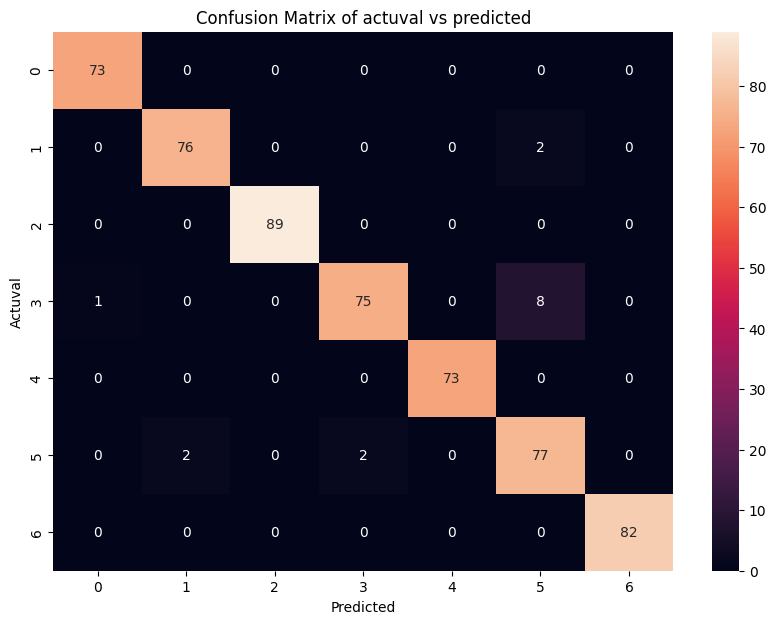

In [31]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True, fmt='g')
plt.ylabel('Actuval')
plt.xlabel('Predicted')
plt.title('Confusion Matrix of actuval vs predicted')
plt.show()

In [32]:
# Evaluate model
eval_results = model.evaluate([X_audio_test, X_text_test], y_test)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.1016 
Test Loss: 0.07600665837526321, Test Accuracy: 0.9732142686843872


In [33]:
# Function to classify a new instance
def classify_new_instance(audio_path, spoken_word):
    """Classifies a new audio-text pair."""
    # Extract features from the audio
    audio_features = extract_features(audio_path)
    audio_features = np.expand_dims(audio_features, axis=0)  # Reshape for model
    
    # Encode the spoken word
    if spoken_word in word_encoder.classes_:
        text_features = word_encoder.transform([spoken_word])
        text_features = np.expand_dims(text_features, axis=-1)
    else:
        print("Word not found in vocabulary!")
        return
    
    # Predict emotion
    prediction = model.predict([audio_features, text_features])
    predicted_label = list(labels_map.keys())[np.argmax(prediction)]
    print(f"Predicted Emotion: {predicted_label}")


In [34]:
# Example usage
classify_new_instance(r"C:\Users\bharg\Downloads\TESS Toronto emotional speech set data\YAF_angry\YAF_week_angry.wav", "shack")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted Emotion: angry
